# Amazon Stock Prices - Time Series Analysis
Ovaj projekat baviće se analizom cene deonica kompanije Amazon i predviđanjem njihove cene u budućnosti.

## Učitavanje i preprocesiranje podataka

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

In [2]:
data = pd.read_csv("amazon_stock.csv")

In [3]:
print(data.head(10))

   Unnamed: 0        Date      Open      High       Low     Close     Volume
0           0  2000-01-03  4.075000  4.478125  3.952344  4.468750  322352000
1           1  2000-01-04  4.268750  4.575000  4.087500  4.096875  349748000
2           2  2000-01-05  3.525000  3.756250  3.400000  3.487500  769148000
3           3  2000-01-06  3.565625  3.634375  3.200000  3.278125  375040000
4           4  2000-01-07  3.350000  3.525000  3.309375  3.478125  210108000
5           5  2000-01-10  3.628125  3.631250  3.278125  3.459375  295158000
6           6  2000-01-11  3.343750  3.500000  3.250000  3.337500  210654000
7           7  2000-01-12  3.393750  3.400000  3.150000  3.178125  216090000
8           8  2000-01-13  3.246875  3.359375  3.156250  3.296875  208962000
9           9  2000-01-14  3.337500  3.431250  3.200000  3.212500  137072000


Nakon učitavanja podataka, možemo uočiti da je kolona označena sa "Unnamed: 0" zapravo višak, i da je možemo odbaciti, što ćemo i uraditi. Takođe, kao indeks tabele postavićemo datum na koji su podaci prikupljeni.

In [4]:
data.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index, format="%Y-%m-%d")

In [5]:
print(data.head())
print(data.info())

                Open      High       Low     Close     Volume
Date                                                         
2000-01-03  4.075000  4.478125  3.952344  4.468750  322352000
2000-01-04  4.268750  4.575000  4.087500  4.096875  349748000
2000-01-05  3.525000  3.756250  3.400000  3.487500  769148000
2000-01-06  3.565625  3.634375  3.200000  3.278125  375040000
2000-01-07  3.350000  3.525000  3.309375  3.478125  210108000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6050 entries, 2000-01-03 to 2024-01-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6050 non-null   float64
 1   High    6050 non-null   float64
 2   Low     6050 non-null   float64
 3   Close   6050 non-null   float64
 4   Volume  6050 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 283.6 KB
None


Na osnovu informacija o dataset-u, možemo videti da su sve kolone numeričkog tipa, i da nema nedostajućih vrednosti, što znači da možemo da nastavimo dalje sa obradom. Pre toga, plotovaćemo sve podatke.

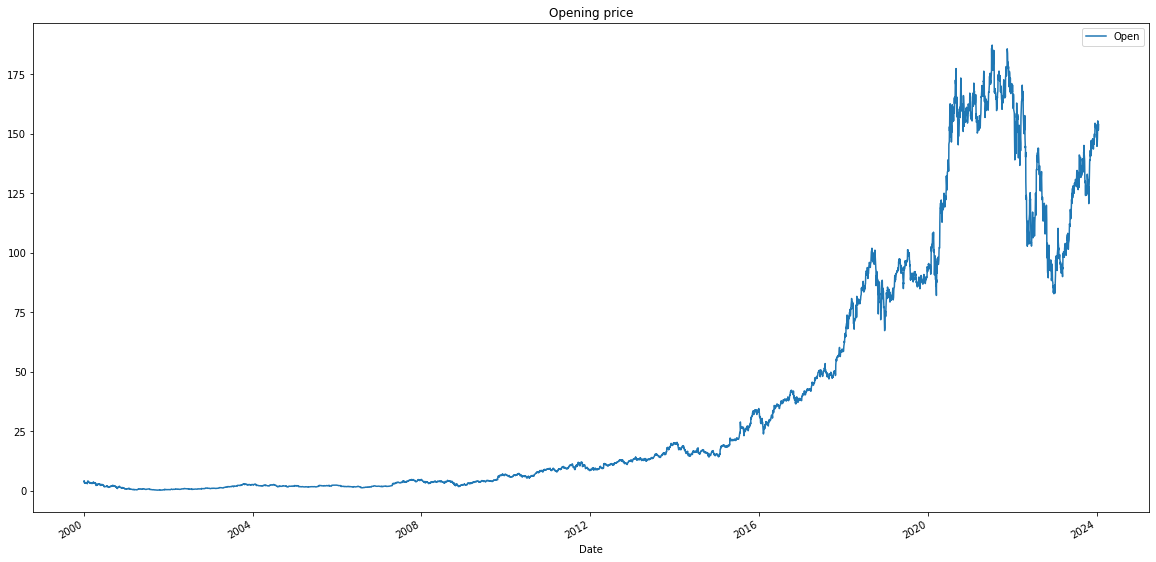

In [6]:
data[["Open"]].plot(figsize=(20, 10))
plt.title("Opening price")
plt.show()

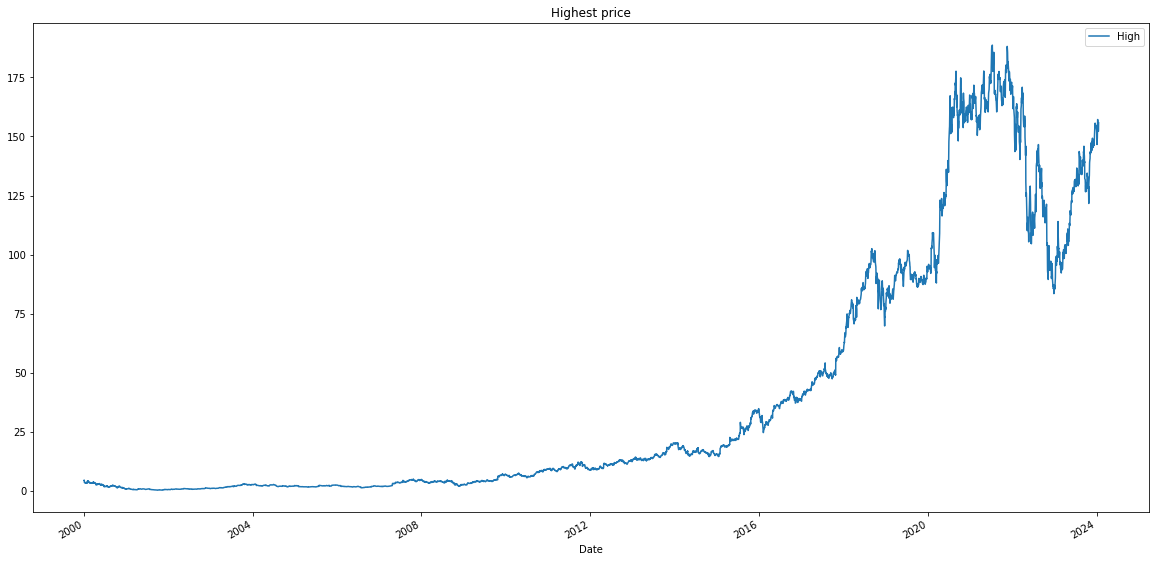

In [7]:
data[["High"]].plot(figsize=(20, 10))
plt.title("Highest price")
plt.show()

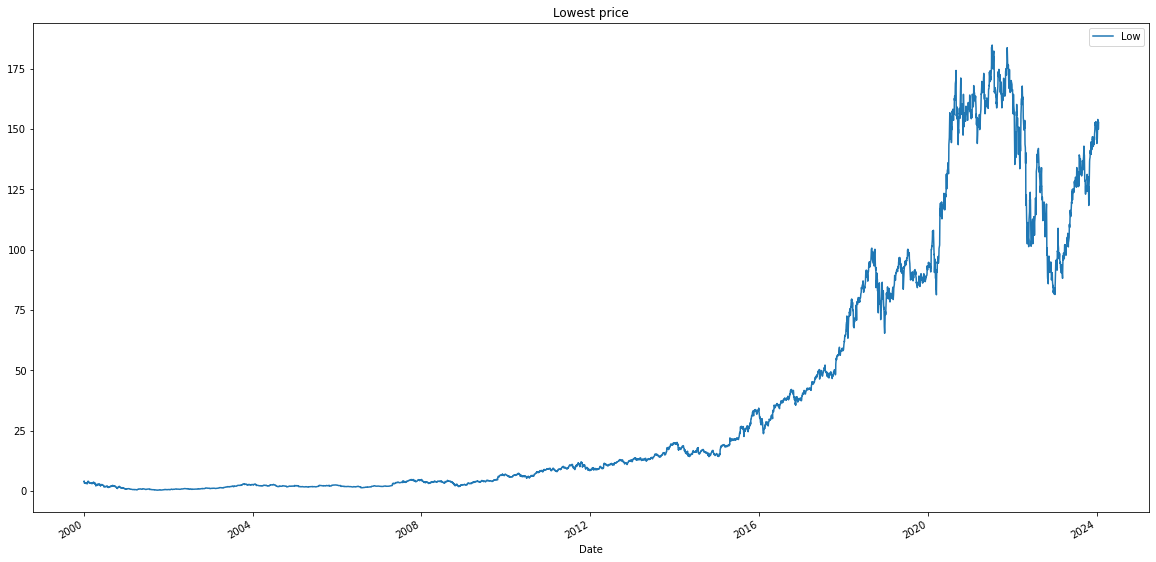

In [8]:
data[["Low"]].plot(figsize=(20, 10))
plt.title("Lowest price")
plt.show()

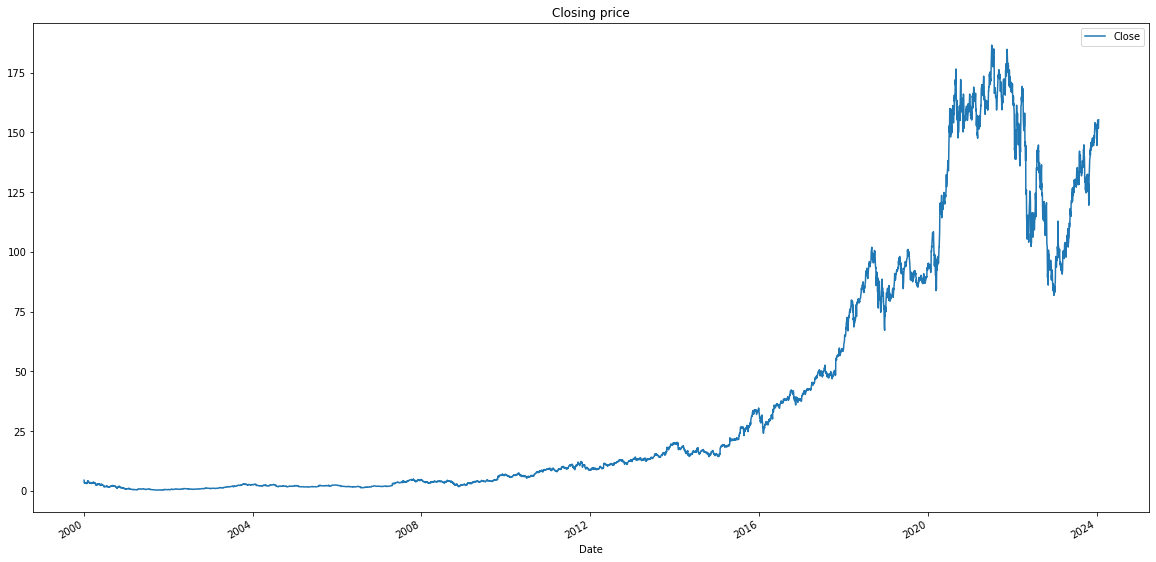

In [9]:
data[["Close"]].plot(figsize=(20, 10))
plt.title("Closing price")
plt.show()

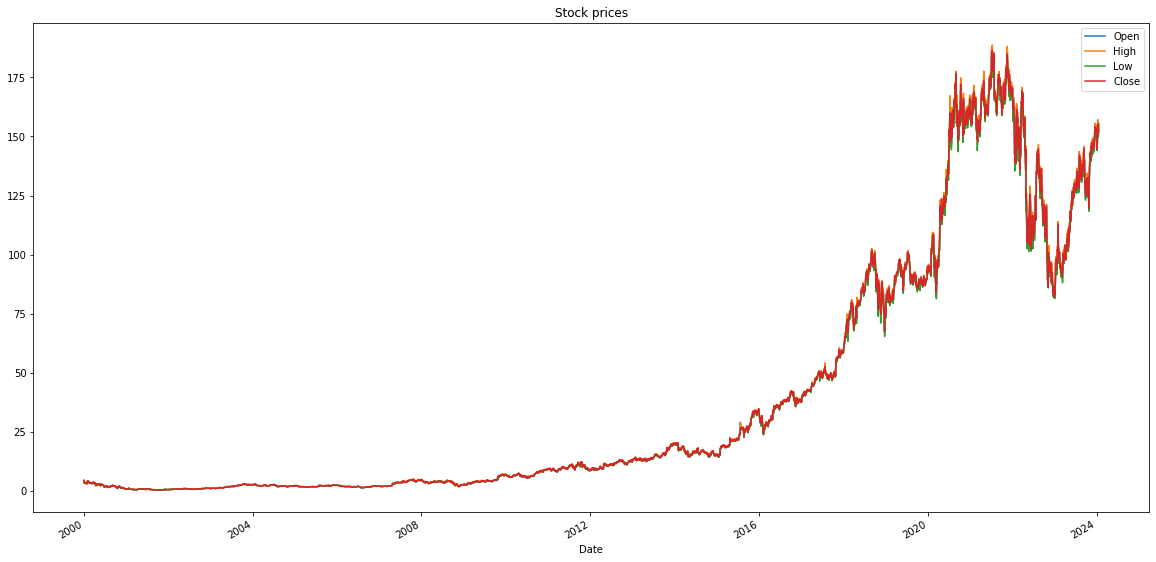

In [10]:
data[["Open", "High", "Low", "Close"]].plot(figsize=(20, 10))
plt.title("Stock prices")
plt.show()

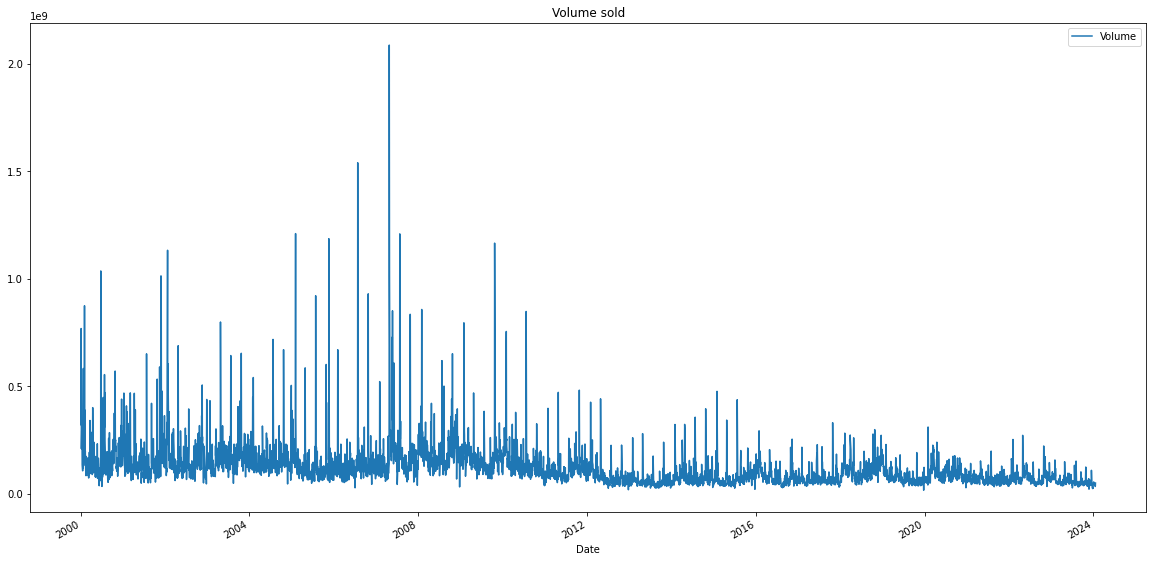

In [11]:
data[["Volume"]].plot(figsize=(20, 10))
plt.title("Volume sold")
plt.show()

Observacijom ovih plot-ova, može se videti da su cene deonica jako malo varirale u periodu do 2009. godine. Zbog toga ćemo prethodne podatke odbaciti i posmatrati samo podatke od 2008. godine pa na dalje.

In [12]:
relevant_data = data["2009":]

In [13]:
print(relevant_data.head(10))
print(relevant_data.info())

              Open    High     Low   Close     Volume
Date                                                 
2009-01-02  2.5675  2.7265  2.5535  2.7180  145928000
2009-01-05  2.7865  2.7870  2.6515  2.7030  190196000
2009-01-06  2.7275  2.9110  2.6875  2.8680  221602000
2009-01-07  2.8145  2.8475  2.7675  2.8100  158854000
2009-01-08  2.7495  2.8660  2.7290  2.8580  131558000
2009-01-09  2.8460  2.8500  2.7350  2.7755  133682000
2009-01-12  2.7060  2.7150  2.5435  2.5960  191126000
2009-01-13  2.5480  2.6645  2.5375  2.5725  157664000
2009-01-14  2.5050  2.5050  2.4070  2.4245  208852000
2009-01-15  2.4280  2.6115  2.3815  2.5720  232346000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3787 entries, 2009-01-02 to 2024-01-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3787 non-null   float64
 1   High    3787 non-null   float64
 2   Low     3787 non-null   float64
 3   Close   3787 non-null   float64
 4   V

Ponovo ćemo plotovati podatke, kako bismo imali uvid u podacima s kojima radimo.

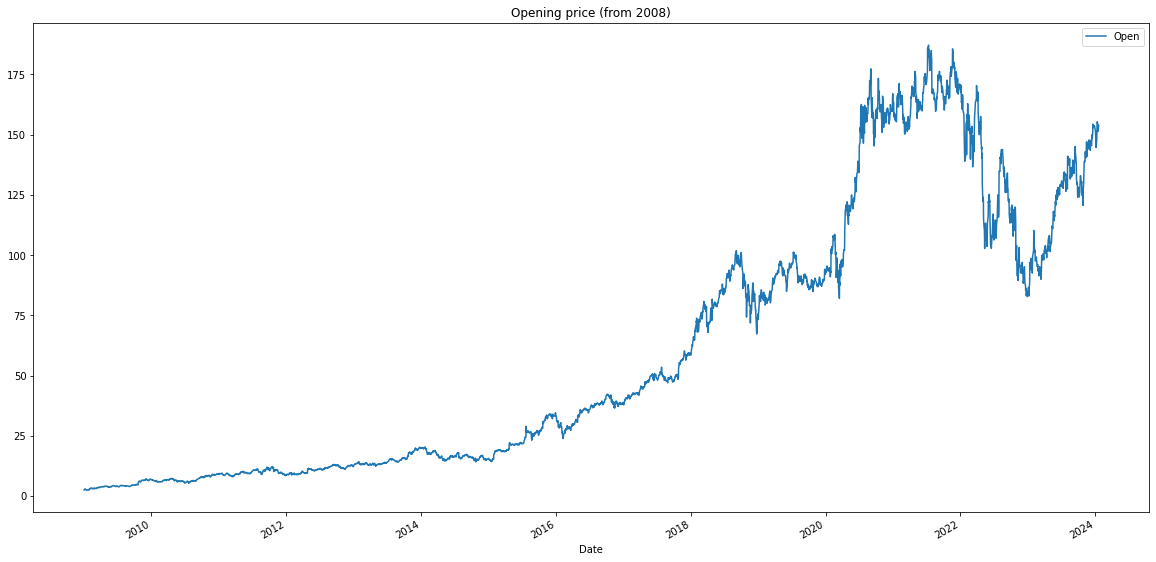

In [14]:
relevant_data[["Open"]].plot(figsize=(20, 10))
plt.title("Opening price (from 2008)")
plt.show()

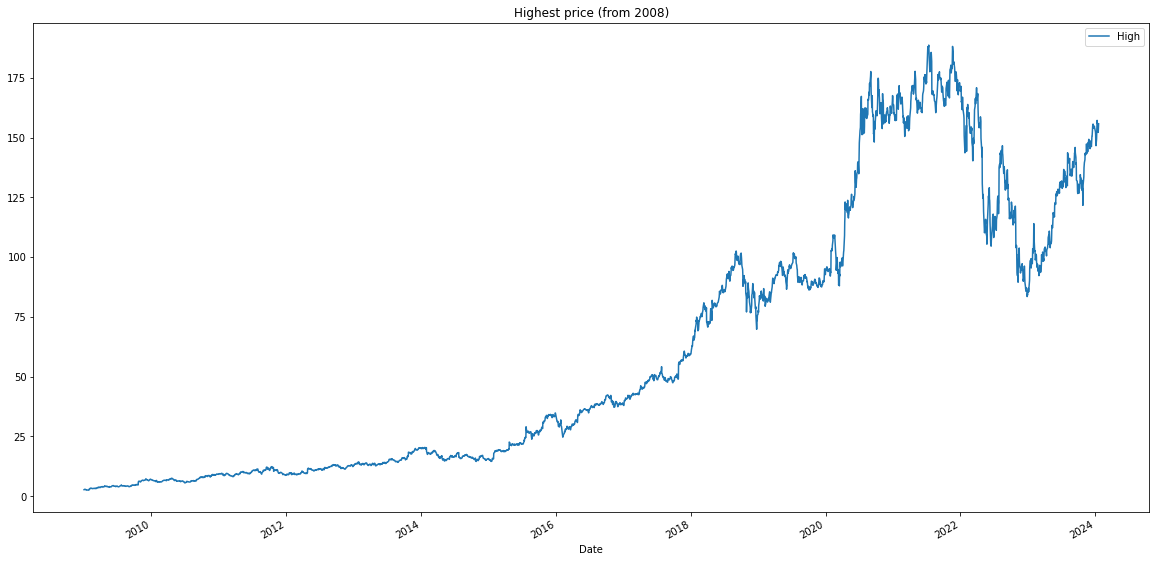

In [15]:
relevant_data[["High"]].plot(figsize=(20, 10))
plt.title("Highest price (from 2008)")
plt.show()

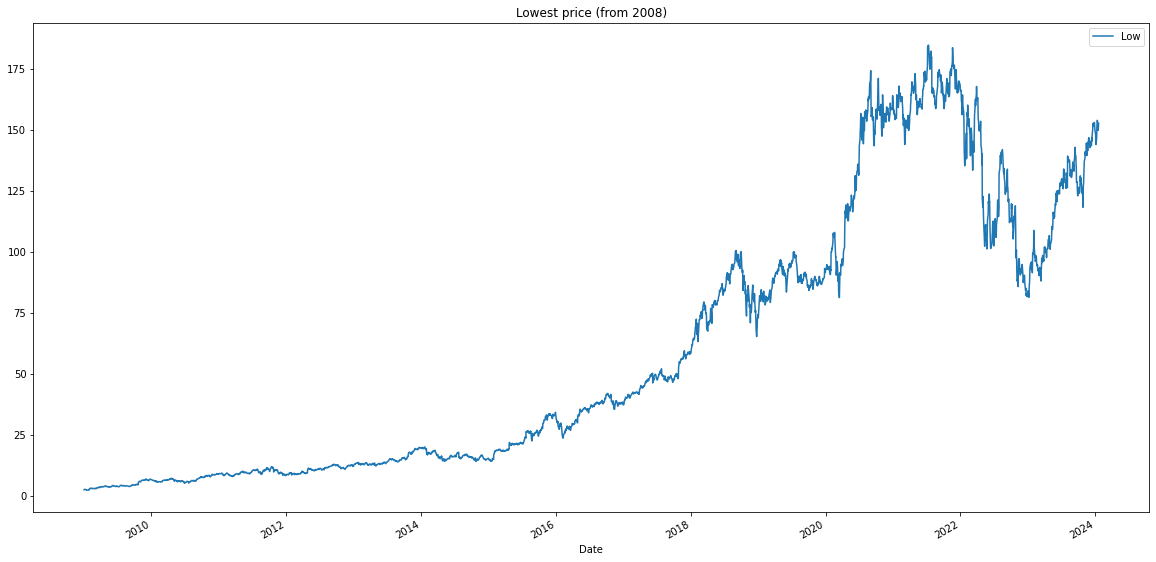

In [16]:
relevant_data[["Low"]].plot(figsize=(20, 10))
plt.title("Lowest price (from 2008)")
plt.show()

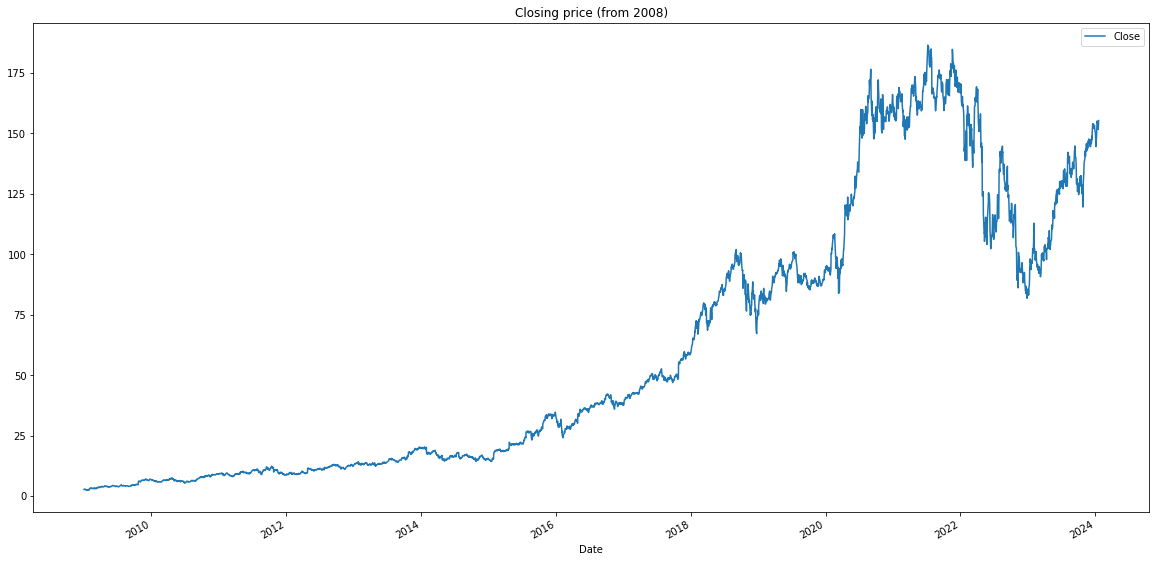

In [17]:
relevant_data[["Close"]].plot(figsize=(20, 10))
plt.title("Closing price (from 2008)")
plt.show()

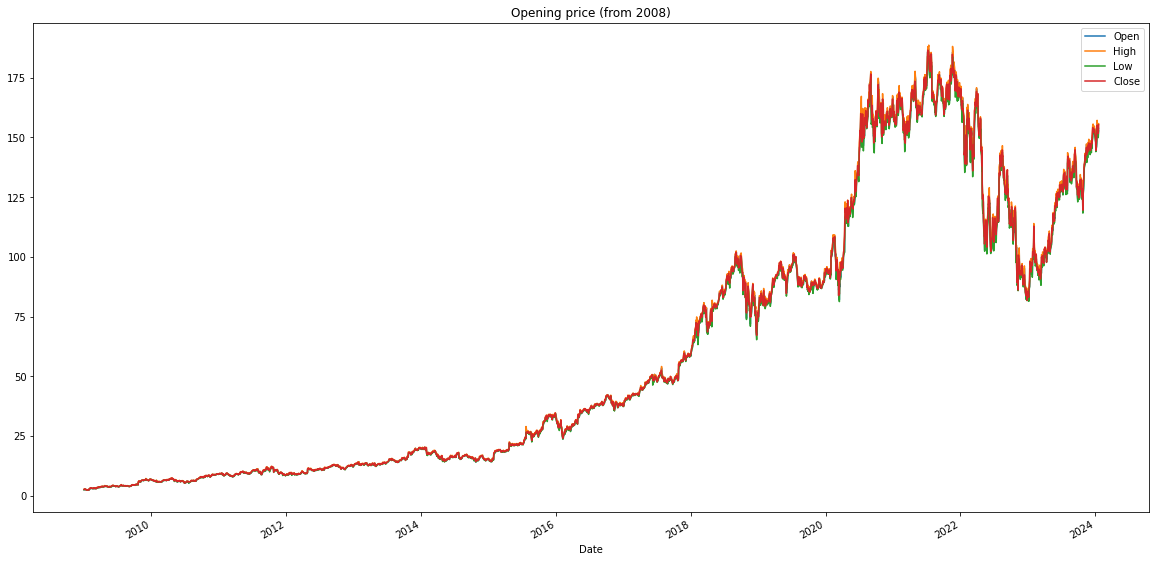

In [18]:
relevant_data[["Open", "High", "Low", "Close"]].plot(figsize=(20, 10))
plt.title("Opening price (from 2008)")
plt.show()

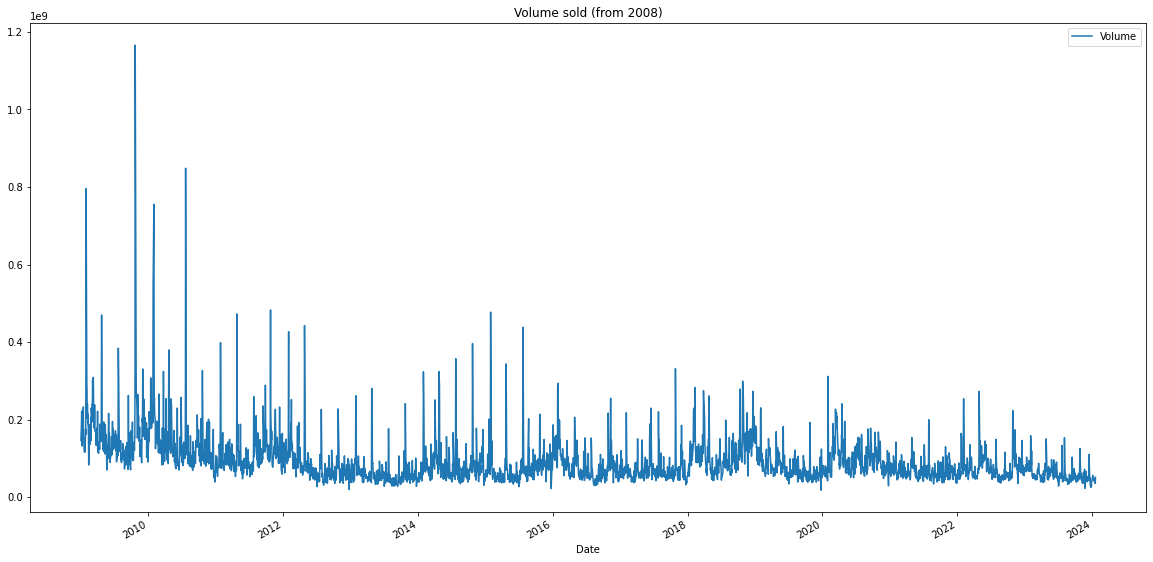

In [19]:
relevant_data[["Volume"]].plot(figsize=(20, 10))
plt.title("Volume sold (from 2008)")
plt.show()

Proverićemo korelaciju između kolona.

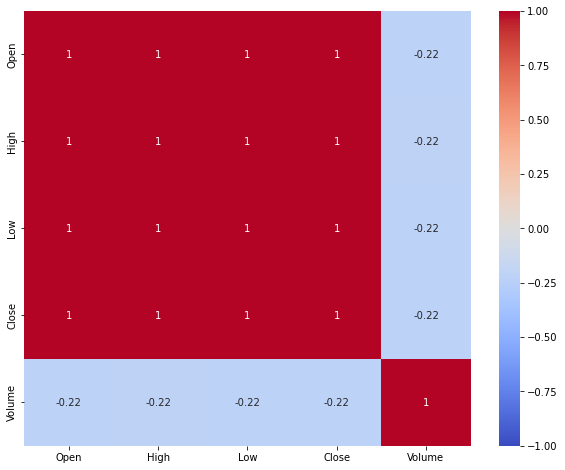

In [20]:
corr_matrix = relevant_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Može se primetiti da su podaci visoko korelisani. Zbog toga, a i zbog lakše obrade podataka, radićemo samo s jednom kolonom, odnosno sa kolonom "High", koju ćemo i predviđati.

## Priprema podataka za mrežu - train i test set

Izvršićemo podelu podataka na trening i test set, i skaliranje tih podaka. Treniraćemo mrežu tako da ona na osnovu vrednosti najviših cena deonica u prethodnih pet dana može da predvidi cenu deonica za sledei dan u nizu.

In [21]:
high_data = relevant_data["High"].to_numpy().astype(np.float32)

In [22]:
train_size = int(len(high_data) * 0.8)
print("Veličina trening seta: ", train_size)

train_data, test_data = high_data[:train_size], high_data[train_size:]
train_data = train_data.reshape((-1, 1))
test_data = test_data.reshape((-1, 1))

Veličina trening seta:  3029


In [23]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [24]:
def create_sequences(data, sequence_length):
    X, y = [], []

    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])

    return np.array(X), np.array(y)

In [25]:
sequence_length = 5
X_train, y_train = create_sequences(train_data, sequence_length)

len_train = np.ceil(X_train.shape[0] * 0.9).astype(np.int32)

X_val, y_val = X_train[len_train:], y_train[len_train:]
X_train, y_train = X_train[0:len_train], y_train[0:len_train]

X_test, y_test = create_sequences(test_data, sequence_length)

## Definisanje custom loss funkcije

Definisaćemo custom loss funkciju, čije ćemo performanse kasnije porediti sa "mean_squared_error" loss funkcijom.

In [26]:
def custom_loss(y_true, y_pred):
    absolute_difference = tf.abs(y_true - y_pred)
    
    direction_penalty = tf.where(tf.sign(y_true - tf.reduce_mean(y_true)) == tf.sign(y_pred - tf.reduce_mean(y_true)), 1.0, 10.0)
    
    loss = tf.reduce_mean(absolute_difference * direction_penalty)
    return loss

## Definisanje Early Stopping uslova

Defnisaćemo i funkciju koju ćemo koristiti za zaustavljanje treninga na osnovu validation loss-a.

In [27]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

Definisaćemo uvek po dva modela: sa ugrađenom i sa custom loss funkcijom. Za oba modela ćemo koristiti early stopping mehanizam. Pored toga, za oba ćemo definisati checkpoint mehanizam koji će sačuvati najbolji model u fajl, iz koga ćemo ga onda učitati i dalje koristiti.

## Definisanje dodatne metrike

Pošto u kerasu nije definisana Root Mean Square error, definisaćemo ovu metriku.

In [28]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## Kreiranje, treniranje i testiranje modela - SimpleRNN

In [29]:
# Ugradjeni loss
mc_srnn = ModelCheckpoint('best_model_srnn.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model_srnn = Sequential()

model_srnn.add(SimpleRNN(units = 20,
                         activation = "relu",
                         return_sequences = False,
                         input_shape = (X_train.shape[1],1)))

model_srnn.add(Dense(20, activation='relu'))

model_srnn.add(Dense(units = 1))

model_srnn.compile(optimizer="adam",
                  loss = "mean_squared_error",
                  metrics = [root_mean_squared_error, "mae", "mape"])

In [30]:
history_srnn = model_srnn.fit(X_train, y_train, epochs = 200, batch_size = 2, validation_data = (X_val, y_val), callbacks=[es, mc_srnn])

Epoch 1/200


1357/1361 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0108 - mae: 0.0094 - mape: 2482.9839
Epoch 1: val_loss improved from inf to 0.01900, saving model to best_model_srnn.h5
1361/1361 [==============================] - 5s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0107 - mae: 0.0094 - mape: 2475.7095 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1088 - val_mae: 0.1084 - val_mape: 12.7779
Epoch 2/200
  60/1361 [>.............................] - ETA: 3s - loss: 4.5654e-05 - root_mean_squared_error: 0.0058 - mae: 0.0052 - mape: 13.5173

C:\Users\andje\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1350/1361 [============================>.] - ETA: 0s - loss: 4.0506e-05 - root_mean_squared_error: 0.0052 - mae: 0.0046 - mape: 2903.8379
Epoch 2: val_loss improved from 0.01900 to 0.01593, saving model to best_model_srnn.h5
1361/1361 [==============================] - 4s 3ms/step - loss: 4.0270e-05 - root_mean_squared_error: 0.0052 - mae: 0.0046 - mape: 2881.0352 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1000 - val_mae: 0.0995 - val_mape: 11.7638
Epoch 3/200
1360/1361 [============================>.] - ETA: 0s - loss: 4.3087e-05 - root_mean_squared_error: 0.0052 - mae: 0.0047 - mape: 2746.8472
Epoch 3: val_loss improved from 0.01593 to 0.01100, saving model to best_model_srnn.h5
1361/1361 [==============================] - 5s 3ms/step - loss: 4.3063e-05 - root_mean_squared_error: 0.0052 - mae: 0.0047 - mape: 2744.8313 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0816 - val_mae: 0.0811 - val_mape: 9.4896
Epoch 4/200
1346/1361 [============================>.] - ETA: 0s 

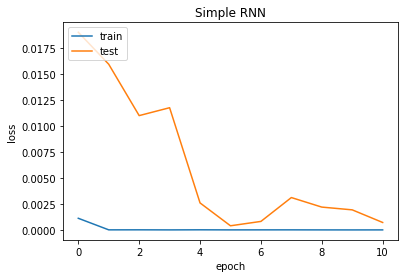

In [31]:
plt.plot(history_srnn.history['loss'])
plt.plot(history_srnn.history['val_loss'])
plt.title('Simple RNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
best_model_srnn = load_model("best_model_srnn.h5", custom_objects={"root_mean_squared_error": root_mean_squared_error})
predictions_srnn = best_model_srnn.predict(X_test)

24/24 [==============================] - 0s 2ms/step


In [33]:
print(best_model_srnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                440       
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 881 (3.44 KB)
Trainable params: 881 (3.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [34]:
mse = np.mean((predictions_srnn - y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00050912023


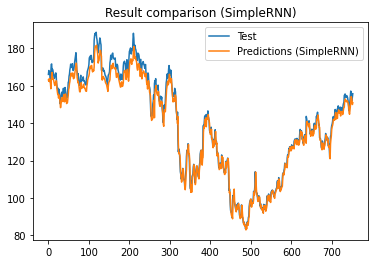

In [35]:
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test), label="Test")
plt.plot(range(len(y_test)), scaler.inverse_transform(predictions_srnn), label="Predictions (SimpleRNN)")
plt.legend()
plt.title("Result comparison (SimpleRNN)")
plt.show()

## Kreiranje, treniranje i testiranje modela - SimpleRNN sa custom loss funkcijom

In [36]:
# Custom loss
mc_srnn_custom = ModelCheckpoint('best_model_srnn_custom.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model_srnn_custom = Sequential()

model_srnn_custom.add(SimpleRNN(units = 20,
                         activation = "relu",
                         return_sequences = False,
                         input_shape = (X_train.shape[1],1)))

model_srnn_custom.add(Dense(20, activation='relu'))

model_srnn_custom.add(Dense(units = 1))

model_srnn_custom.compile(optimizer="adam",
                  loss = custom_loss,
                  metrics = [root_mean_squared_error, "mae", "mape"])

In [37]:
history_srnn_custom = model_srnn_custom.fit(X_train, y_train, epochs = 200, batch_size = 2, validation_data = (X_val, y_val), callbacks=[es, mc_srnn_custom])

Epoch 1/200
1350/1361 [============================>.] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.0098 - mae: 0.0088 - mape: 3059.8362
Epoch 1: val_loss improved from inf to 0.19774, saving model to best_model_srnn_custom.h5
1361/1361 [==============================] - 6s 3ms/step - loss: 0.0157 - root_mean_squared_error: 0.0098 - mae: 0.0087 - mape: 3035.1460 - val_loss: 0.1977 - val_root_mean_squared_error: 0.0327 - val_mae: 0.0318 - val_mape: 4.3288
Epoch 2/200
  35/1361 [..............................] - ETA: 4s - loss: 0.0246 - root_mean_squared_error: 0.0154 - mae: 0.0138 - mape: 29.2527

C:\Users\andje\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1361/1361 [==============================] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0079 - mae: 0.0070 - mape: 1875.5120
Epoch 2: val_loss improved from 0.19774 to 0.12438, saving model to best_model_srnn_custom.h5
1361/1361 [==============================] - 5s 3ms/step - loss: 0.0116 - root_mean_squared_error: 0.0079 - mae: 0.0070 - mape: 1875.5120 - val_loss: 0.1244 - val_root_mean_squared_error: 0.0201 - val_mae: 0.0189 - val_mape: 2.5784
Epoch 3/200
1348/1361 [============================>.] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0066 - mae: 0.0059 - mape: 4122.4956
Epoch 3: val_loss improved from 0.12438 to 0.10569, saving model to best_model_srnn_custom.h5
1361/1361 [==============================] - 5s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0066 - mae: 0.0059 - mape: 4083.2637 - val_loss: 0.1057 - val_root_mean_squared_error: 0.0170 - val_mae: 0.0157 - val_mape: 2.1693
Epoch 4/200
1352/1361 [============================>.] - ETA: 0s - l

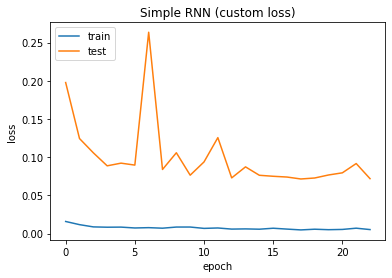

In [38]:
plt.plot(history_srnn_custom.history['loss'])
plt.plot(history_srnn_custom.history['val_loss'])
plt.title('Simple RNN (custom loss)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
best_model_srnn_custom = load_model("best_model_srnn_custom.h5", custom_objects={"custom_loss": custom_loss, "root_mean_squared_error": root_mean_squared_error})
predictions_srnn_custom = best_model_srnn_custom.predict(X_test)

24/24 [==============================] - 0s 2ms/step


In [40]:
print(best_model_srnn_custom.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 20)                440       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 881 (3.44 KB)
Trainable params: 881 (3.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [41]:
mse = np.mean((predictions_srnn_custom - y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00025156705


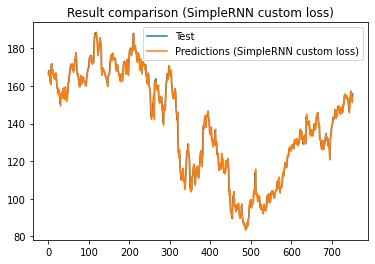

In [42]:
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test), label="Test")
plt.plot(range(len(y_test)), scaler.inverse_transform(predictions_srnn_custom), label="Predictions (SimpleRNN custom loss)")
plt.legend()
plt.title("Result comparison (SimpleRNN custom loss)")
plt.show()

## Kreiranje, treniranje i testiranje modela - LSTM

In [43]:
mc_lstm = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model_lstm = Sequential()
model_lstm.add(LSTM(units=40, input_shape=(sequence_length, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer=Adam(learning_rate = 0.02), loss='mean_squared_error', metrics = [root_mean_squared_error, "mae", "mape"])

In [44]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=200, batch_size=5, validation_data=(X_val, y_val), callbacks=[es, mc_lstm])

Epoch 1/200
532/545 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0264 - mae: 0.0216 - mape: 8522.7598
Epoch 1: val_loss improved from inf to 0.00156, saving model to best_model_lstm.h5
545/545 [==============================] - 5s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0263 - mae: 0.0215 - mape: 8330.3418 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0329 - val_mae: 0.0302 - val_mape: 3.7413
Epoch 2/200
 43/545 [=>............................] - ETA: 1s - loss: 0.0011 - root_mean_squared_error: 0.0303 - mae: 0.0262 - mape: 57.7953   

C:\Users\andje\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


537/545 [============================>.] - ETA: 0s - loss: 7.6507e-04 - root_mean_squared_error: 0.0240 - mae: 0.0197 - mape: 11122.0742
Epoch 2: val_loss did not improve from 0.00156
545/545 [==============================] - 2s 4ms/step - loss: 7.6242e-04 - root_mean_squared_error: 0.0240 - mae: 0.0197 - mape: 10971.2656 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0873 - val_mae: 0.0860 - val_mape: 11.3779
Epoch 3/200
541/545 [============================>.] - ETA: 0s - loss: 4.9906e-04 - root_mean_squared_error: 0.0199 - mae: 0.0162 - mape: 14280.6240
Epoch 3: val_loss did not improve from 0.00156
545/545 [==============================] - 3s 5ms/step - loss: 4.9998e-04 - root_mean_squared_error: 0.0199 - mae: 0.0163 - mape: 14191.8311 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1376 - val_mae: 0.1365 - val_mape: 17.8832
Epoch 4/200
540/545 [============================>.] - ETA: 0s - loss: 4.9627e-04 - root_mean_squared_error: 0.0200 - mae: 0.0163 - mape: 5829.6992


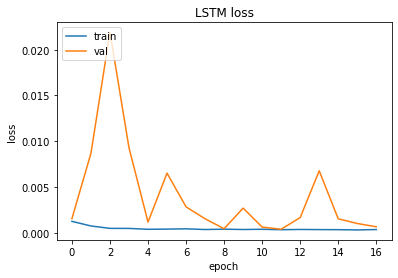

In [45]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
best_model_lstm = load_model("best_model_lstm.h5", custom_objects={"root_mean_squared_error": root_mean_squared_error})
predictions_lstm = best_model_lstm.predict(X_test)

24/24 [==============================] - 1s 2ms/step


In [47]:
print(best_model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
Total params: 6761 (26.41 KB)
Trainable params: 6761 (26.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [48]:
mse = np.mean((predictions_lstm - y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00041102176


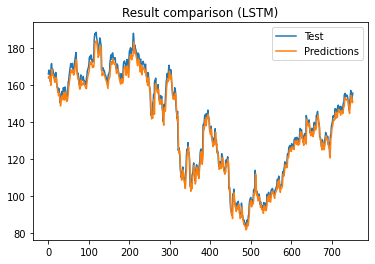

In [49]:
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test), label="Test")
plt.plot(range(len(y_test)), scaler.inverse_transform(predictions_lstm), label="Predictions")
plt.legend()
plt.title("Result comparison (LSTM)")
plt.show()

## Kreiranje, treniranje i testiranje modela - LSTM sa custom loss funkcijom

In [50]:
mc_lstm_custom = ModelCheckpoint('best_model_lstm_custom.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model_lstm_custom = Sequential()
model_lstm_custom.add(LSTM(units=40, input_shape=(sequence_length, 1)))
model_lstm_custom.add(Dropout(0.2))
model_lstm_custom.add(Dense(units=1))
model_lstm_custom.compile(optimizer=Adam(learning_rate = 0.02), loss=custom_loss, metrics = [root_mean_squared_error, "mae", "mape"])

In [51]:
history_lstm_custom = model_lstm_custom.fit(X_train, y_train, epochs=200, batch_size=5, validation_data=(X_val, y_val), callbacks=[es, mc_lstm_custom])

Epoch 1/200
534/545 [============================>.] - ETA: 0s - loss: 0.0621 - root_mean_squared_error: 0.0380 - mae: 0.0305 - mape: 23051.2266
Epoch 1: val_loss improved from inf to 0.51082, saving model to best_model_lstm_custom.h5
545/545 [==============================] - 4s 4ms/step - loss: 0.0616 - root_mean_squared_error: 0.0378 - mae: 0.0304 - mape: 22612.6875 - val_loss: 0.5108 - val_root_mean_squared_error: 0.0868 - val_mae: 0.0855 - val_mape: 11.1840
Epoch 2/200
 49/545 [=>............................] - ETA: 1s - loss: 0.0286 - root_mean_squared_error: 0.0235 - mae: 0.0187 - mape: 29.1865

C:\Users\andje\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


542/545 [============================>.] - ETA: 0s - loss: 0.0334 - root_mean_squared_error: 0.0265 - mae: 0.0214 - mape: 1001.7339
Epoch 2: val_loss improved from 0.51082 to 0.36873, saving model to best_model_lstm_custom.h5
545/545 [==============================] - 2s 4ms/step - loss: 0.0335 - root_mean_squared_error: 0.0266 - mae: 0.0215 - mape: 997.4238 - val_loss: 0.3687 - val_root_mean_squared_error: 0.0624 - val_mae: 0.0606 - val_mape: 8.2517
Epoch 3/200
540/545 [============================>.] - ETA: 0s - loss: 0.0267 - root_mean_squared_error: 0.0243 - mae: 0.0193 - mape: 1705.2850
Epoch 3: val_loss did not improve from 0.36873
545/545 [==============================] - 3s 5ms/step - loss: 0.0267 - root_mean_squared_error: 0.0243 - mae: 0.0193 - mape: 1691.6925 - val_loss: 0.7874 - val_root_mean_squared_error: 0.1375 - val_mae: 0.1363 - val_mape: 17.6208
Epoch 4/200
534/545 [============================>.] - ETA: 0s - loss: 0.0235 - root_mean_squared_error: 0.0206 - mae: 0.01

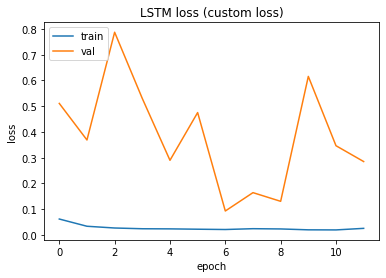

In [52]:
plt.plot(history_lstm_custom.history['loss'])
plt.plot(history_lstm_custom.history['val_loss'])
plt.title('LSTM loss (custom loss)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
best_model_lstm_custom = load_model("best_model_lstm_custom.h5", custom_objects={"custom_loss": custom_loss, "root_mean_squared_error": root_mean_squared_error})
predictions_lstm_custom = best_model_lstm_custom.predict(X_test)

24/24 [==============================] - 0s 2ms/step


In [54]:
print(best_model_lstm_custom.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 40)                6720      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 41        
                                                                 
Total params: 6761 (26.41 KB)
Trainable params: 6761 (26.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [55]:
mse = np.mean((predictions_lstm_custom - y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00048709253


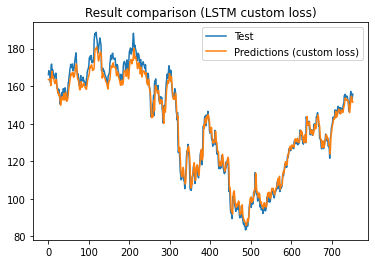

In [56]:
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test), label="Test")
plt.plot(range(len(y_test)), scaler.inverse_transform(predictions_lstm_custom), label="Predictions (custom loss)")
plt.legend()
plt.title("Result comparison (LSTM custom loss)")
plt.show()

## Kreiranje, treniranje i testiranje modela - GRU

In [57]:
mc_gru = ModelCheckpoint('best_model_gru.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model_gru = Sequential()
 
model_gru.add(GRU(units=25, 
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))

model_gru.add(Dropout(0.2))

model_gru.add(GRU(units=25, 
                  return_sequences=False,
                  activation='tanh'))

model_gru.add(Dense(units=1,
                    activation='relu'))

model_gru.compile(optimizer=SGD(learning_rate=0.001, 
                                   momentum=0.9, 
                                   nesterov=False),
                                   loss='mean_squared_error',
                                   metrics = [root_mean_squared_error, "mae", "mape"])

In [58]:
history_gru = model_gru.fit(X_train, y_train, epochs = 200, batch_size = 5, validation_data=(X_val, y_val), callbacks=[es, mc_gru])

Epoch 1/200
541/545 [============================>.] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.1079 - mae: 0.0919 - mape: 41135.4219
Epoch 1: val_loss improved from inf to 0.07003, saving model to best_model_gru.h5
545/545 [==============================] - 7s 7ms/step - loss: 0.0139 - root_mean_squared_error: 0.1077 - mae: 0.0917 - mape: 40878.9336 - val_loss: 0.0700 - val_root_mean_squared_error: 0.2533 - val_mae: 0.2523 - val_mape: 33.9029
Epoch 2/200
 21/545 [>.............................] - ETA: 2s - loss: 0.0059 - root_mean_squared_error: 0.0722 - mae: 0.0637 - mape: 460.5401

C:\Users\andje\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


542/545 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0413 - mae: 0.0348 - mape: 11046.4756
Epoch 2: val_loss improved from 0.07003 to 0.01067, saving model to best_model_gru.h5
545/545 [==============================] - 4s 7ms/step - loss: 0.0022 - root_mean_squared_error: 0.0412 - mae: 0.0347 - mape: 10997.8359 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0974 - val_mae: 0.0962 - val_mape: 12.8017
Epoch 3/200
542/545 [============================>.] - ETA: 0s - loss: 5.3335e-04 - root_mean_squared_error: 0.0193 - mae: 0.0147 - mape: 2755.4402
Epoch 3: val_loss improved from 0.01067 to 0.00173, saving model to best_model_gru.h5
545/545 [==============================] - 4s 7ms/step - loss: 5.3468e-04 - root_mean_squared_error: 0.0194 - mae: 0.0147 - mape: 2743.3616 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0362 - val_mae: 0.0336 - val_mape: 4.3020
Epoch 4/200
541/545 [============================>.] - ETA: 0s - loss: 3.9182e-04

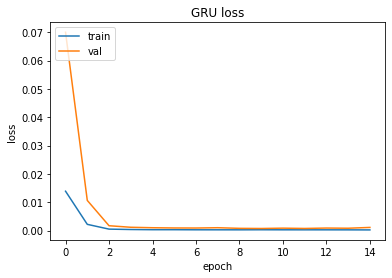

In [59]:
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('GRU loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
best_model_gru = load_model("best_model_gru.h5", custom_objects={"root_mean_squared_error": root_mean_squared_error})
predictions_gru = model_gru.predict(X_test)

24/24 [==============================] - 1s 3ms/step


In [61]:
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 25)             2100      
                                                                 
 dropout_2 (Dropout)         (None, 5, 25)             0         
                                                                 
 gru_1 (GRU)                 (None, 25)                3900      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 6026 (23.54 KB)
Trainable params: 6026 (23.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
mse = np.mean((predictions_gru - y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0012538274


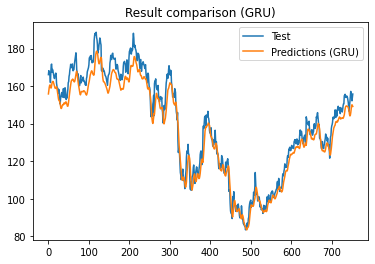

In [63]:
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test), label="Test")
plt.plot(range(len(y_test)), scaler.inverse_transform(predictions_gru), label="Predictions (GRU)")
plt.legend()
plt.title("Result comparison (GRU)")
plt.show()

## Kreiranje, treniranje i testiranje modela - GRU sa custom loss funkcijom

In [64]:
mc_gru_custom = ModelCheckpoint('best_model_gru_custom.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model_gru_custom = Sequential()
 
model_gru_custom.add(GRU(units=25, 
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))

model_gru_custom.add(Dropout(0.2))

model_gru_custom.add(GRU(units=25, 
                  return_sequences=False,
                  activation='tanh'))

model_gru_custom.add(Dense(units=1,
                    activation='relu'))

model_gru_custom.compile(optimizer=SGD(learning_rate=0.001, 
                                   momentum=0.9, 
                                   nesterov=False),
                                   loss='mean_squared_error',
                                   metrics = [root_mean_squared_error, "mae", "mape"])

In [65]:
history_gru_custom = model_gru_custom.fit(X_train, y_train, epochs = 200, batch_size = 5, validation_data=(X_val, y_val), callbacks=[es, mc_gru_custom])

Epoch 1/200
543/545 [============================>.] - ETA: 0s - loss: 0.0231 - root_mean_squared_error: 0.1382 - mae: 0.1153 - mape: 1223.7814
Epoch 1: val_loss improved from inf to 0.09299, saving model to best_model_gru_custom.h5
545/545 [==============================] - 7s 7ms/step - loss: 0.0230 - root_mean_squared_error: 0.1379 - mae: 0.1151 - mape: 1220.7743 - val_loss: 0.0930 - val_root_mean_squared_error: 0.2904 - val_mae: 0.2893 - val_mape: 38.6756
Epoch 2/200
 25/545 [>.............................] - ETA: 3s - loss: 0.0068 - root_mean_squared_error: 0.0798 - mae: 0.0701 - mape: 178.4183

C:\Users\andje\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


542/545 [============================>.] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0514 - mae: 0.0435 - mape: 30987.6934
Epoch 2: val_loss improved from 0.09299 to 0.01148, saving model to best_model_gru_custom.h5
545/545 [==============================] - 4s 7ms/step - loss: 0.0033 - root_mean_squared_error: 0.0512 - mae: 0.0434 - mape: 30851.1719 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1009 - val_mae: 0.0997 - val_mape: 13.2503
Epoch 3/200
544/545 [============================>.] - ETA: 0s - loss: 5.8562e-04 - root_mean_squared_error: 0.0202 - mae: 0.0154 - mape: 6183.7876
Epoch 3: val_loss improved from 0.01148 to 0.00238, saving model to best_model_gru_custom.h5
545/545 [==============================] - 4s 7ms/step - loss: 5.8519e-04 - root_mean_squared_error: 0.0201 - mae: 0.0154 - mape: 6179.2529 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0438 - val_mae: 0.0415 - val_mape: 5.4200
Epoch 4/200
539/545 [============================>.] - ETA: 0s - lo

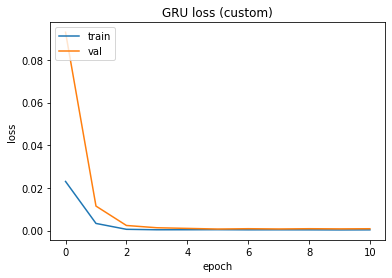

In [66]:
plt.plot(history_gru_custom.history['loss'])
plt.plot(history_gru_custom.history['val_loss'])
plt.title('GRU loss (custom)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
best_model_gru_custom = load_model("best_model_gru_custom.h5", custom_objects={'custom_loss': custom_loss, "root_mean_squared_error": root_mean_squared_error})
predictions_gru_custom = best_model_gru_custom.predict(X_test)

24/24 [==============================] - 1s 4ms/step


In [68]:
print(best_model_gru.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 25)             2100      
                                                                 
 dropout_2 (Dropout)         (None, 5, 25)             0         
                                                                 
 gru_1 (GRU)                 (None, 25)                3900      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 6026 (23.54 KB)
Trainable params: 6026 (23.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [69]:
mse = np.mean((predictions_gru - y_test) ** 2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0012538274


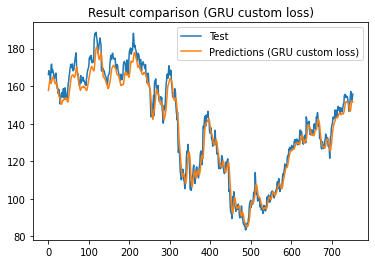

In [70]:
plt.plot(range(len(y_test)), scaler.inverse_transform(y_test), label="Test")
plt.plot(range(len(y_test)), scaler.inverse_transform(predictions_gru_custom), label="Predictions (GRU custom loss)")
plt.legend()
plt.title("Result comparison (GRU custom loss)")
plt.show()

## Prikaz rezultata

U nastavku će u tebeli biti prikazano poređenje metrika dobijenih korišćenjem različitih kombinacija mrežnih arhitektura i loss funkcija. (podaci se odnose na model koji se checkpoint sačuvao kao najbolji) (ovo je u kontekstu loss funkcije, tako da je manja vrednost bolja)

|Mrežni slojevi|Loss funkcija|val_loss|val_rmse|val_mae|val_mape|mse na test podacima|
|:------------:|:-----------:|:--------:|:----------:|:-----:|:------:|:------------------:|
|   SimpleRNN  |     MSE     |0.00043073|0.01649997|0.01527186|1.95270788|0.00050912|
|   SimpleRNN  | Custom loss |0.07141680|**0.01219791**|**0.01074773**|**1.45062065**|**0.00025157**|
|     LSTM     |     MSE     |0.00040664|0.01838261|0.01576029|2.17075181|0.00041102|
|     LSTM     | Custom loss |0.09276512|0.01775730|0.01524704|2.09217119|0.00048709|
|      GRU     |     MSE     |0.00075908|0.02285696|0.02040326|2.63751196|0.00125382|
|      GRU     | Custom loss |0.00071317|0.02202053|0.01968889|2.57029747|0.00125382|

Za parametre i custom loss funkciju datu u ovoj svesci, najbolje se pokazala SimpleRNN mreža sa custom loss funkcijom, dok su se najgore pokazale varijante GRU mreže. Što se tiče naše custom loss funkcije, u sve tri mreže su statistike računane na validacionom dataset-u bile bolje sa custom loss funkcijom nego sa mean square error ugrađenom funkcijom, ali je na realnim podacima LSTM mreža trenirana sa custom loss funkcijom dala lošije rezultate. Sve ovo je direktno zavisno od zadatih parametara mreže, dakle, za različite parametre mogli bi se dobiti različiti rezultati.